In [ ]:
#This notebook accompanies the paper titled “VeLU: Variance-Enhanced Learning Unit for Deep Neural Networks.”

In [ ]:
"""Package Requirement
Python: 3.9.7
Tensorflow: 2.6.0
Keras: 2.6.0
"""

'Package Requirement\nPython: 3.9.7\nTensorflow: 2.6.0\nKeras: 2.6.0\n'

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import psutil
import gc
from vit_keras import vit

In [8]:
'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset path
data_dir = "D:/Local daatset address"
num_classes = XX

# Preprocess images
#data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.15)
data_gen = ImageDataGenerator(validation_split=0.2)

# Load training & validation data
train_data = data_gen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=64, subset="training")
val_data = data_gen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=64, subset="validation")

print(f"Loaded dataset from {data_dir}: {train_data.samples} training samples, {val_data.samples} validation samples")'''


'\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\n\n# Define dataset path\ndata_dir = "D:/Local daatset address"\nnum_classes = XX\n\n# Preprocess images\n#data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.15)\ndata_gen = ImageDataGenerator(validation_split=0.2)\n\n# Load training & validation data\ntrain_data = data_gen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=64, subset="training")\nval_data = data_gen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=64, subset="validation")\n\nprint(f"Loaded dataset from {data_dir}: {train_data.samples} training samples, {val_data.samples} validation samples")'

In [9]:
# Load CIFAR-100 Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
num_classes = 10

# Normalize pixel values
x_train, x_test = x_train.astype("float32") / 255.0, x_test.astype("float32") / 255.0

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Function to resize images one at a time to save memory
def resize_image(img, label):
    img = tf.image.resize(img, [128, 128])  # Resize single image
    return img, label

# Use tf.data to process images in a memory-efficient way
batch_size = 32#64  # Adjust batch size based on available memory

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)  # Prefetch to improve efficiency
)

val_data = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Check dataset structure
for img, label in train_data.take(1):
    print("Resized batch shape:", img.shape, label.shape)


Resized batch shape: (32, 128, 128, 3) (32, 10)


In [10]:
'''# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
num_classes = 10

# Expand dimensions to (batch, height, width, channels)
x_train = np.expand_dims(x_train, axis=-1)  # (60000, 28, 28) -> (60000, 28, 28, 1)
x_test  = np.expand_dims(x_test, axis=-1)

# Resize images to (32, 32, 1)
x_train = tf.image.resize(x_train, [32, 32])
x_test  = tf.image.resize(x_test, [32, 32])

# Convert grayscale (1 channel) to RGB (3 channels)
x_train = tf.image.grayscale_to_rgb(x_train)  # (60000, 32, 32, 1) -> (60000, 32, 32, 3)
x_test  = tf.image.grayscale_to_rgb(x_test)

# Normalize AFTER resizing (for efficiency)
x_train = x_train * 0.0039215686  # Equivalent to / 255.0
x_test  = x_test * 0.0039215686  # Equivalent to / 255.0

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

print("Train:", x_train.shape, y_train.shape)  # Expected: (60000, 32, 32, 3)
print("Test: ", x_test.shape, y_test.shape)    # Expected: (10000, 32, 32, 3)'''

'# Load MNIST dataset\n(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()\n#(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()\nnum_classes = 10\n\n# Expand dimensions to (batch, height, width, channels)\nx_train = np.expand_dims(x_train, axis=-1)  # (60000, 28, 28) -> (60000, 28, 28, 1)\nx_test  = np.expand_dims(x_test, axis=-1)\n\n# Resize images to (32, 32, 1)\nx_train = tf.image.resize(x_train, [32, 32])\nx_test  = tf.image.resize(x_test, [32, 32])\n\n# Convert grayscale (1 channel) to RGB (3 channels)\nx_train = tf.image.grayscale_to_rgb(x_train)  # (60000, 32, 32, 1) -> (60000, 32, 32, 3)\nx_test  = tf.image.grayscale_to_rgb(x_test)\n\n# Normalize AFTER resizing (for efficiency)\nx_train = x_train * 0.0039215686  # Equivalent to / 255.0\nx_test  = x_test * 0.0039215686  # Equivalent to / 255.0\n\n# Convert labels to one-hot encoding\ny_train = keras.utils.to_categorical(y_train, num_classes)\ny_test  = keras.utils.to_categorical(y

In [11]:
class Velu(layers.Layer):
    def __init__(self, alpha=0.1, beta1=0.1, beta2=0.1, gamma=0.1, momentum=0.9, lambda_ot=0.1, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.gamma = gamma
        self.momentum = momentum
        self.lambda_ot = lambda_ot
        self.lambda_ = self.add_weight(name="lambda_", shape=(), initializer="ones", trainable=True)

    def wasserstein_distance(self, x):
        """
        Computes the Wasserstein distance between the activation output and the target Gaussian distribution.
        """
        target_mean = 0.0
        target_std = 1.0
        x_mean = tf.reduce_mean(x)
        x_std = tf.math.reduce_std(x)
        
        w_dist = tf.square(x_mean - target_mean) + tf.square(x_std - target_std)
        return w_dist

    def call(self, x):
        # Compute standard deviation for adaptive scaling
        variance = tf.reduce_mean(tf.square(x), axis=-1, keepdims=True)
        std_dev = tf.math.rsqrt(variance + 1e-6)
        #std_dev = tf.math.rsqrt(variance + 1e-3)

        adapt_factor = 1.0 + self.gamma * tf.math.tanh(std_dev * self.momentum)

        # Combine arc-tan and arc-sin transformations
        clipped = tf.clip_by_value(self.beta2 * x, -1.0, 1.0)
        mix = tf.math.atan(self.beta1 * x) + tf.math.asin(clipped)

        # Compute the activation output
        activation = x * tf.keras.activations.sigmoid(self.alpha * mix) * adapt_factor
        #activation = x * tf.keras.activations.sigmoid(self.alpha * mix) * tf.clip_by_value(adapt_factor, 0.01, 0.1)

        # Compute Wasserstein regularization
        w_dist = self.wasserstein_distance(activation)
        reg_loss = self.lambda_ot * w_dist

        # Add Wasserstein loss to the total loss function
        self.add_loss(reg_loss)

        return self.lambda_ * activation

    def get_config(self):
        config = super().get_config()
        config.update({
            "alpha": self.alpha,
            "beta1": self.beta1,
            "beta2": self.beta2,
            "gamma": self.gamma,
            "momentum": self.momentum,
            "lambda_ot": self.lambda_ot,
        })
        return config

def velu(alpha=0.1, beta1=0.1, beta2=0.1, gamma=0.1, momentum=0.9, lambda_ot=0.1):
    return Velu(alpha, beta1, beta2, gamma, momentum, lambda_ot)


In [12]:
def plot_results(results_plot, figure_size=(14, 5)):
    """
    Function to plot validation accuracy and loss from results.

    Parameters:
        results_plot (dict): A dictionary containing model results, 
                             including 'history' with accuracy and loss values.
        figure_size (tuple): Size of the figure, default is (14, 5).
    """
    # Create a new figure for the plots
    plt.figure(figsize=figure_size)

    # Plot Validation Accuracy
    plt.subplot(1, 2, 1)
    for name, res in results_plot.items():
        if "history" in res:  # Ensure 'history' data exists
            val_acc = res["history"].get("val_accuracy", [])
            epochs_range = range(1, len(val_acc) + 1)
            plt.plot(epochs_range, val_acc, label=f"{name} - Val Acc")

    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title("Comparison of Activation Functions - Validation Accuracy")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.6)

    # Plot Validation Loss
    plt.subplot(1, 2, 2)
    for name, res in results_plot.items():
        if "history" in res:  # Ensure 'history' data exists
            val_loss = res["history"].get("val_loss", [])
            epochs_range = range(1, len(val_loss) + 1)
            plt.plot(epochs_range, val_loss, label=f"{name} - Val Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title("Comparison of Activation Functions - Validation Loss")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.6)

    # Show the plots
    plt.tight_layout()
    plt.show()

In [13]:
# Function to Replace All Activation Functions
def replace_activations_with_velu(model):
    for i, layer in enumerate(model.layers):
        # Case 1: If the layer has an activation attribute (Dense, Conv2D, etc.)
        if hasattr(layer, "activation") and callable(layer.activation):
            if layer.activation in [tf.keras.activations.relu, tf.nn.relu6, 
                                    tf.keras.activations.swish, tf.nn.swish, 
                                    tf.nn.gelu, tf.keras.activations.gelu]:
                config = layer.get_config()  # Get layer config
                print(f"🔹 Replacing activation in {layer.name} ({type(layer).__name__}) with VeLU")
                config["activation"] = velu  # Update activation
                
                # Rebuild layer with updated activation
                model.layers[i] = type(layer).from_config(config)

        # Case 2: If the layer is an explicit activation layer (ReLU, Swish, GELU, ReLU6)
        elif isinstance(layer, (tf.keras.layers.ReLU, tf.keras.layers.Activation)):
            if hasattr(layer, "activation") and callable(layer.activation):
                if layer.activation in [tf.keras.activations.relu, tf.nn.relu6, 
                                        tf.keras.activations.swish, tf.nn.swish, 
                                        tf.nn.gelu, tf.keras.activations.gelu]:
                    # Replace activation function safely
                    print(f"🔸 Replacing explicit activation layer {layer.name} with VeLU")
                    model.layers[i] = tf.keras.layers.Activation(activation=velu)

    # Recompile the model after modifying activations
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    print(" Model successfully updated with Velu and recompiled.")
    return model

In [ ]:
# Function to measure inference speed
def measure_inference_speed(model, sample_input, runs=100):
    start_time = time.time()
    for _ in range(runs):
        _ = model.predict(sample_input, verbose=0)
    total_time = time.time() - start_time
    return runs / total_time  # FPS (Frames Per Second)

# Function to get memory usage
def get_memory_usage():
    return psutil.virtual_memory().used / (1024 ** 2)  # Convert bytes to MB

# Dictionary to store results
results = {}
results_Plot = {}

img_vit_size=(128, 128)
img_size = (128, 128, 3)

# Define Target Models
target_models = {
    
    #"ViT": lambda: vit.vit_b16(image_size=img_vit_size, pretrained=True, include_top=False, pretrained_top=False,  weights = "imagenet21k+imagenet2012"),
    "ResNet50": lambda: tf.keras.applications.ResNet50(include_top=False, input_shape=img_size, weights="imagenet"),
    #"EfficientNetB3": lambda: tf.keras.applications.EfficientNetB3(include_top=False, input_shape=img_size, weights="imagenet"),
    #"VGG19": lambda: tf.keras.applications.VGG19(include_top=False, input_shape=img_size, weights="imagenet"),
    #"DenseNet121": lambda: tf.keras.applications.DenseNet121(include_top=False, input_shape=img_size, weights="imagenet"),
    #"MobileNetV2": lambda: tf.keras.applications.MobileNetV2(include_top=False, input_shape=img_size, weights="imagenet"),
}

# Loop Over Models
for model_name, base_model_fn in target_models.items():
    
    # Detect the original activation function used in the model
    base_model_temp = base_model_fn()
    original_activation = None

    for layer in base_model_temp.layers:
        if isinstance(layer, tf.keras.layers.ReLU):
            original_activation = "relu"
            break
        elif hasattr(layer, "activation") and layer.activation == tf.keras.activations.swish:
            original_activation = tf.keras.activations.swish
            break
        elif hasattr(layer, "activation") and layer.activation == tf.nn.gelu:
            original_activation = tf.nn.gelu
            break
        elif hasattr(layer, "activation") and layer.activation == tf.nn.relu6:
            original_activation = tf.nn.relu6
            break

    del base_model_temp
    gc.collect()
    tf.keras.backend.clear_session()

    # Loop Over Two Activation Configurations: Original & Velu
    for act_name, act_fn in {
        "Velu": velu()#,
        #"Original": original_activation
    }.items():
        print(f"===== Training {model_name} with {act_name} Activation =====")

        # Clear memory before creating a new model
        tf.keras.backend.clear_session()
        gc.collect()

        # Load the base model
        base_model = base_model_fn()

        # Modify activations only for Velu
        for layer in base_model.layers:
            if isinstance(layer, tf.keras.layers.ReLU):  
                original_activation = "relu"
                break
            elif hasattr(layer, "activation") and layer.activation in [tf.keras.activations.swish, tf.nn.swish]:
                original_activation = tf.keras.activations.swish
                break

            elif hasattr(layer, "activation") and layer.activation == tf.nn.gelu:
                original_activation = tf.nn.gelu
                break

            elif hasattr(layer, "activation") and layer.activation == tf.nn.relu6:
                original_activation = tf.nn.relu6
                break

        if act_name == "Velu":
            print("Velu is replacing...")
            base_model = replace_activations_with_velu(base_model)


        # Build Model
        inputs = tf.keras.Input(shape=(128, 128, 3))
        x = base_model(inputs, training=True)
        if model_name == "ViT":  
            print("ViT")  # ViT outputs 2D tensor
            b_size = 8#32
            eph = 1
        else:
            x = tf.keras.layers.GlobalAveragePooling2D()(x)
            b_size = 64#16#256
            eph = 15
        
        x = tf.keras.layers.Dense(256, activation=act_fn)(x)
        x = tf.keras.layers.Dense(64, activation=act_fn)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
        
        model = tf.keras.Model(inputs, outputs)

        # Compile Model
        model.compile(
            #optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
            optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
            #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipvalue=0.5),
            #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),

            loss="categorical_crossentropy",
            metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top_5_acc")]
        )

        # Train Model
        start_time = time.time()
        history = model.fit(train_data, validation_data=val_data, epochs=eph, batch_size=b_size, verbose=1)
        training_time = time.time() - start_time

        # Evaluate Model
        eval_results = model.evaluate(val_data, verbose=0)
        test_loss = eval_results[0]  # First metric is loss
        test_acc = eval_results[1]  # Second metric is accuracy
        test_top5_acc = eval_results[2] if len(eval_results) > 2 else None  

        # Measure Inference Speed
        sample_input = tf.random.normal((1, 128, 128, 3))
        inference_speed = measure_inference_speed(model, sample_input)

        # Measure Memory Usage
        memory_usage = get_memory_usage()

        # Store Results
        results[f"{model_name}_{act_name}"] = {
            "Model": model_name,
            "Activation": act_name,
            "Top-1 Accuracy (%)": round(test_acc * 100, 2),
            "Top-5 Accuracy (%)": round(test_top5_acc * 100, 2) if test_top5_acc is not None else "N/A",
            "Loss": round(test_loss, 4),
            "Training Time (s)": round(training_time, 2),
            "Inference Speed (FPS)": round(inference_speed, 2),
            "Memory Usage (MB)": round(memory_usage, 2),
        }
        
        # Store Training History
        results_Plot[f"{model_name}_{act_name}"] = {"history": history.history}

        print(f"{model_name} with {act_name} - Test Accuracy: {test_acc:.4f}\n")

        # Free Memory
        del model, base_model
        gc.collect()
        tf.keras.backend.clear_session()

    plot_results(results_plot=results_Plot)
    results_Plot = {}

# Convert results to Pandas DataFrame
df_results = pd.DataFrame(results).T

# Print results
print(df_results.to_string(index=False))

# Save Results
excel_filename = "Results.xlsx"
df_results.to_excel(excel_filename, index=True)

print(f"Results saved to {excel_filename}")

===== Training ResNet50 with Velu Activation =====
Velu is replacing...
🔹 Replacing activation in conv1_relu (Activation) with VeLU
🔹 Replacing activation in conv2_block1_1_relu (Activation) with VeLU
🔹 Replacing activation in conv2_block1_2_relu (Activation) with VeLU
🔹 Replacing activation in conv2_block1_out (Activation) with VeLU
🔹 Replacing activation in conv2_block2_1_relu (Activation) with VeLU
🔹 Replacing activation in conv2_block2_2_relu (Activation) with VeLU
🔹 Replacing activation in conv2_block2_out (Activation) with VeLU
🔹 Replacing activation in conv2_block3_1_relu (Activation) with VeLU
🔹 Replacing activation in conv2_block3_2_relu (Activation) with VeLU
🔹 Replacing activation in conv2_block3_out (Activation) with VeLU
🔹 Replacing activation in conv3_block1_1_relu (Activation) with VeLU
🔹 Replacing activation in conv3_block1_2_relu (Activation) with VeLU
🔹 Replacing activation in conv3_block1_out (Activation) with VeLU
🔹 Replacing activation in conv3_block2_1_relu (Activ

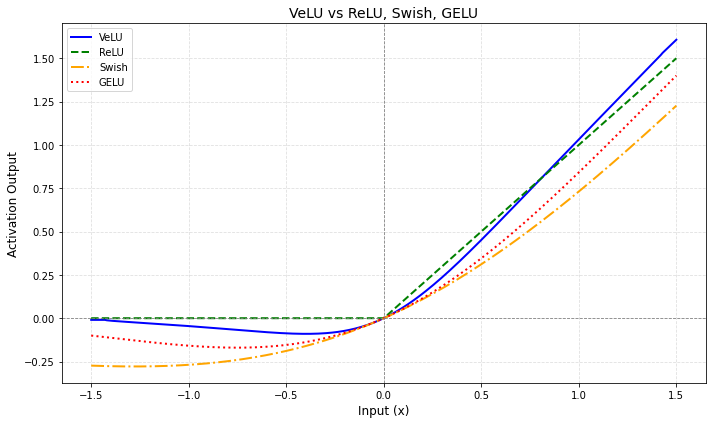

In [ ]:
# ----------------------
# Visualization: VeLU vs ReLU, Swish, and GeLU
# ----------------------

def velu(alpha=0.1, beta1=0.1, beta2=0.1, gamma=0.1, momentum=0.9, lambda_ot=0.1):
    return Velu(alpha, beta1, beta2, gamma, momentum, lambda_ot)


# Create a range of x values
x_vals = np.linspace(-1.5, 1.5, 300)

# Initialize VeLU
velu_activation = velu(alpha=2.0, beta1=1.0, beta2=0.7, gamma=0.1, momentum=0.9, lambda_ot=0.1)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot VeLU
x_tf = tf.constant(x_vals, dtype=tf.float32)
y_velu = velu_activation(x_tf).numpy()
plt.plot(x_vals, y_velu, label="VeLU", linewidth=2, color="blue")

# Plot ReLU
y_relu = tf.nn.relu(x_tf).numpy()
plt.plot(x_vals, y_relu, label="ReLU", linestyle="--", linewidth=2, color="green")

# Plot Swish
y_swish = tf.nn.swish(x_tf).numpy()
plt.plot(x_vals, y_swish, label="Swish", linestyle="-.", linewidth=2, color="orange")

# Plot GELU
y_gelu = tf.nn.gelu(x_tf).numpy()
plt.plot(x_vals, y_gelu, label="GELU", linestyle=":", linewidth=2, color="red")

# Add reference lines
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.8, linestyle='--')

# Titles and labels
plt.title("VeLU vs ReLU, Swish, GELU", fontsize=14)
plt.xlabel("Input (x)", fontsize=12)
plt.ylabel("Activation Output", fontsize=12)

# Add legend
plt.legend(fontsize=10, loc="upper left")

# Add grid
plt.grid(alpha=0.4, linestyle='--')

# Optimize layout and show
plt.tight_layout()
plt.show()
